# Visualizing Bit Properties of Regulatory Regions

## Setup

### Import Required Modules

In [2]:
# built-in modules
from itertools import product
from pathlib import Path
import sys
from typing import List, Tuple

# third-party modules
from Bio.Alphabet import IUPAC
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from tqdm import tqdm
from scipy.stats import iqr
import seaborn as sns

# local modules
BITOME_KB_PATH = Path('..', 'bitome-kb')
sys.path.append(BITOME_KB_PATH.absolute().as_posix())
from bitome.core import Bitome
from bitome.utilities import bits_per_bp_plot

### Set Global Variables

In [3]:
FIG_PATH = Path('..', 'figures', 'figure_3')
LOCAL_CACHE_PATH = Path('..', 'local_cache')

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']

### Load Bitome KB

In [4]:
test_bitome = Bitome.init_from_file(Path(LOCAL_CACHE_PATH, 'bitome.pkl'))

## Figures

### Initial Processing of Regulatory Regions

In [5]:
promoters = [promoter for promoter in test_bitome.promoters if promoter.transcription_unit is not None]

dists_to_minus_10 = []
dists_to_minus_35 = []
spacer_lengths = []
for promoter in promoters:
    # assume promoters have both boxes if one is present
    box_10_location = promoter.box_10_location
    box_35_location = promoter.box_35_location
    if box_10_location is not None:
        # define the average position of the -10/-35 boxes; need to subtract 1 from the end because it is NOT inclusive
        minus_10_center = abs(box_10_location.start.position + box_10_location.end.position-1)/2
        minus_35_center = abs(box_35_location.start.position + box_35_location.end.position-1)/2
        tss = promoter.tss_location.start.position
        dists_to_minus_10.append(abs(tss-minus_10_center))
        dists_to_minus_35.append(abs(tss-minus_35_center))
        
        # also want to get the distance between the edges of the things (hacky way where I don't have to check strand)
        spacer_length = min(np.abs([
            box_10_location.start.position - box_35_location.end.position,
            box_10_location.end.position - box_35_location.start.position
        ]))
        spacer_lengths.append(spacer_length)

dist_to_minus_10 = np.array(dists_to_minus_10) * -1
dist_to_minus_35 = np.array(dists_to_minus_35) * -1
dist_to_minus_10_median = np.median(dist_to_minus_10)
dist_to_minus_35_median = np.median(dist_to_minus_35)

# --- want to define the inter-TU vs TU regions ---
tu_sub_matrix = test_bitome.extract(row_labels=['TU'], base_name=True)
tu_vector = np.asarray(tu_sub_matrix.sum(axis=0)).flatten()
inter_tu_locs = np.where(tu_vector == 0)[0]

# want to get tuple ranges for the inter-TU regions
current_start = inter_tu_locs[0]
previous = current_start
remaining_locs = inter_tu_locs[1:]
inter_tu_ranges = []
while len(remaining_locs) > 0:
    if remaining_locs[0] - previous == 1:
        previous = remaining_locs[0]
        remaining_locs = remaining_locs[1:]
        continue
    else:
        inter_tu_ranges.append((current_start, previous))
        current_start = remaining_locs[0]
        previous = current_start
        remaining_locs = remaining_locs[1:]
inter_tu_ranges = [tup for tup in inter_tu_ranges if tup[0] < tup[1]]

# --- operon- and TU-based bits per bp calculations ---
operon_intergenic_ranges = []
for operon in test_bitome.operons:

    operon_tus = operon.transcription_units
    operon_genes = []
    for tu in operon_tus:
        operon_genes += tu.genes
    operon_genes = list(set(operon_genes))

    if not operon_genes:
        continue

    intergenic_ranges = []
    gene_ranges = [(gene.location.start.position, gene.location.end.position) for gene in operon_genes]

    strand = operon.location.strand
    if strand == 1:
        sorted_ranges_left = sorted(gene_ranges, key=lambda tup: tup[0])
        for i, current_range in enumerate(sorted_ranges_left):
            if i == 0:
                continue
            else:
                previous_range = sorted_ranges_left[i-1]
                if current_range[0] > previous_range[1]:
                    operon_intergenic_ranges.append((previous_range[1], current_range[0]))
    else:
        sorted_ranges_right = sorted(gene_ranges, key=lambda tup: tup[1], reverse=True)
        for i, current_range in enumerate(sorted_ranges_right):
            if i == 0:
                continue
            else:
                previous_range = sorted_ranges_right[i-1]
                if current_range[1] < previous_range[0]:
                    operon_intergenic_ranges.append((current_range[1], previous_range[0]))

five_prime_utr_ranges = []
three_prime_utr_ranges = []
tus = [tu for tu in test_bitome.transcription_units if tu.genes and tu.promoter is not None]
for tu in tus:

    tu_genes = tu.genes
    tu_strand = tu.location.strand
    if tu_strand == 1:
        translation_start = min([gene.location.start.position for gene in tu_genes])
        translation_end = max([gene.location.end.position for gene in tu_genes])
        five_prime_utr_range = tu.tss, translation_start
        three_prime_utr_range = translation_end, tu.tts
    else:
        translation_start = max([gene.location.end.position for gene in tu_genes])
        translation_end = min([gene.location.start.position for gene in tu_genes])
        five_prime_utr_range = translation_start, tu.tss
        three_prime_utr_range = tu.tts, translation_end

    # we may not actually have a five or three prime UTR
    if five_prime_utr_range[0] < five_prime_utr_range[1]:
        five_prime_utr_ranges.append(five_prime_utr_range)
    if three_prime_utr_range[0] < three_prime_utr_range[1]:
        three_prime_utr_ranges.append(three_prime_utr_range)

five_prime_utr_lengths = [utr_5_range[1] - utr_5_range[0] for utr_5_range in five_prime_utr_ranges]
three_prime_utr_lengths = [utr_3_range[1] - utr_3_range[0] for utr_3_range in three_prime_utr_ranges]


def outlier_indices(lengths: list) -> np.array:
    """
    Given a list of UTR lengths, return indices of outliers based on 1.5*IQR
    :param list lengths: the UTR lengths
    :return np.array outlier_indices: the indices of the outliers as defined above
    """
    length_iqr = iqr(lengths)
    q1 = np.percentile(lengths, 25)
    q3 = np.percentile(lengths, 75)
    indices = []
    for idx, length in enumerate(lengths):
        if length < (q1-length_iqr*1.5) or length > (q3+length_iqr*1.5):
            indices.append(idx)
    return indices


five_prime_utr_outliers = outlier_indices(five_prime_utr_lengths)
three_prime_utr_outliers = outlier_indices(three_prime_utr_lengths)

five_prime_utr_ranges_no_outliers = np.delete(np.array(five_prime_utr_ranges), five_prime_utr_outliers, axis=0)
three_prime_utr_ranges_no_outliers = np.delete(np.array(three_prime_utr_ranges), three_prime_utr_outliers, axis=0)

five_prime_utr_lengths_no_outliers = [
    utr_5_range[1] - utr_5_range[0]
    for utr_5_range in five_prime_utr_ranges_no_outliers
]
three_prime_utr_lengths_no_outliers = [
    utr_3_range[1] - utr_3_range[0]
    for utr_3_range in three_prime_utr_ranges_no_outliers
]

### Core Promoter Elements

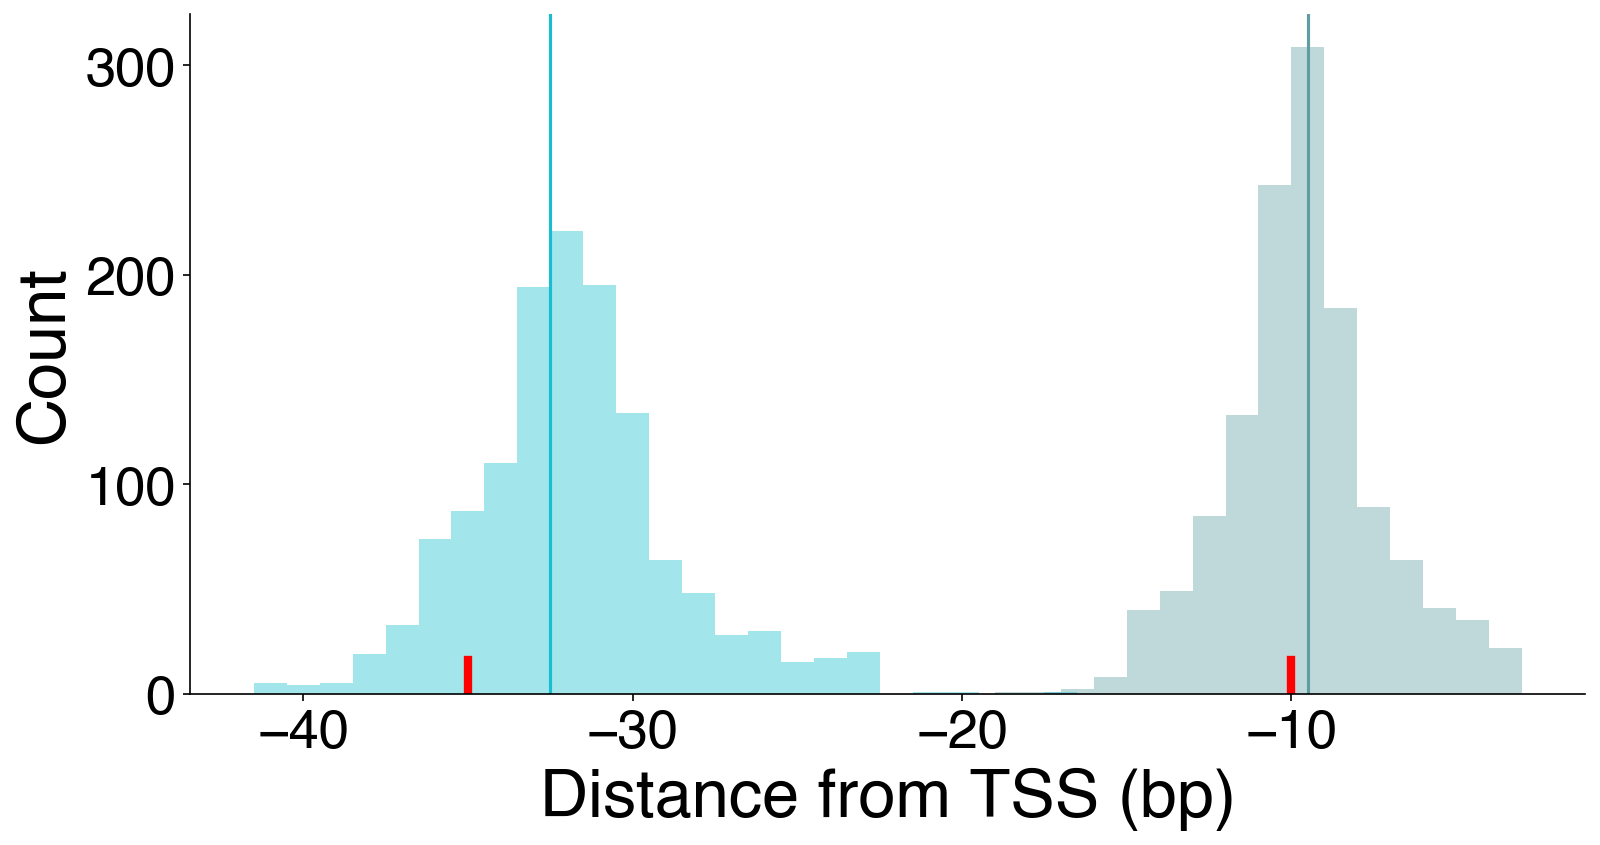

In [6]:
_, ax = plt.subplots(figsize=(12, 6))
sns.distplot(dist_to_minus_10, bins=16, kde=False, color='cadetblue')
sns.distplot(dist_to_minus_35, bins=25, kde=False, color='tab:cyan')
ax.axvline(x=-10, ymax=0.05, color='r', linewidth=4)
ax.axvline(x=-35, ymax=0.05, color='r', linewidth=4)
ax.axvline(x=dist_to_minus_10_median, color='cadetblue')
ax.axvline(x=dist_to_minus_35_median, color='tab:cyan')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Distance from TSS (bp)', fontsize=32)
ax.set_ylabel('Count', fontsize=32)
ax.tick_params(axis='both', labelsize='26')
plt.savefig(Path(FIG_PATH, 'promoter_elements.svg'))
plt.show()

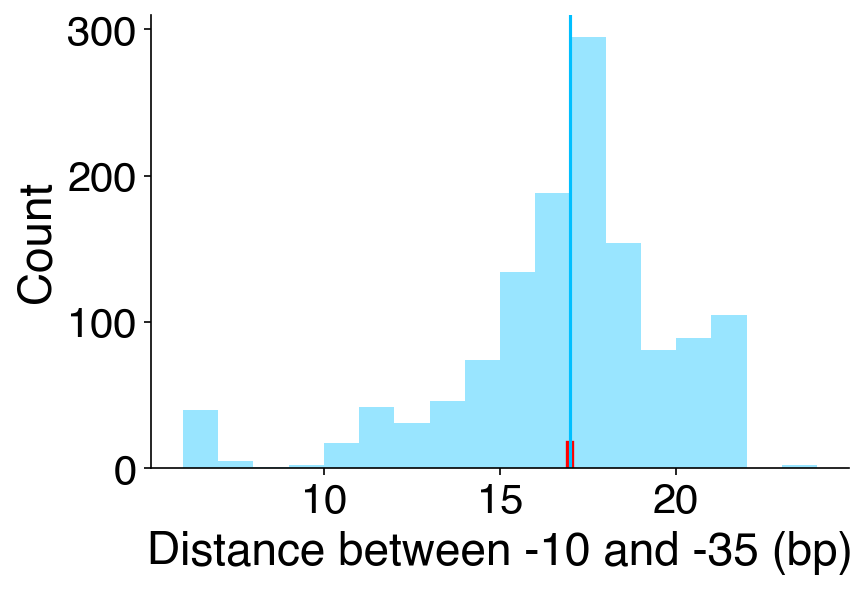

In [7]:
_, ax = plt.subplots()
sns.distplot(spacer_lengths, color='deepskyblue', kde=False, bins=np.arange(6, 25))
ax.axvline(x=17, ymax=0.05, color='r', linewidth=4)
ax.axvline(x=np.median(spacer_lengths), color='deepskyblue')
ax.set_xlabel('Distance between -10 and -35 (bp)', fontsize=22)
ax.set_ylabel('Count', fontsize=22)
ax.tick_params(axis='both', labelsize='20')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(Path(FIG_PATH, 'elements_diff.svg'))
plt.show()

### UTRs

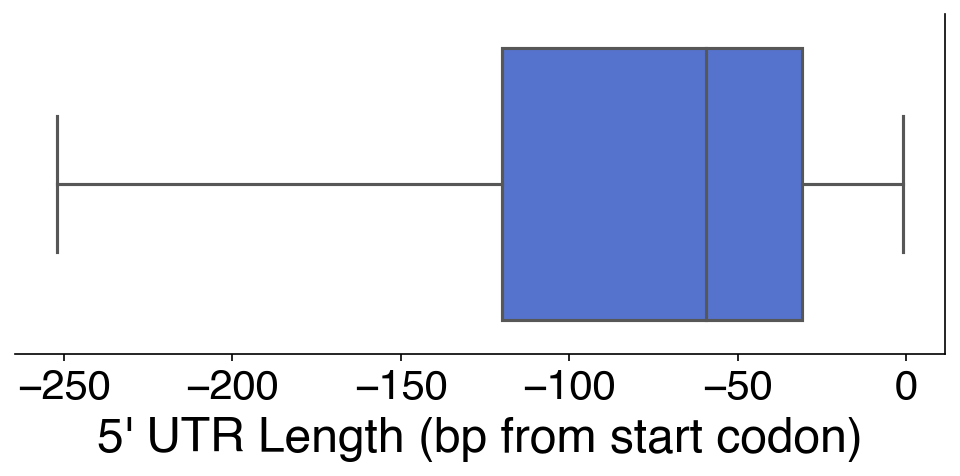

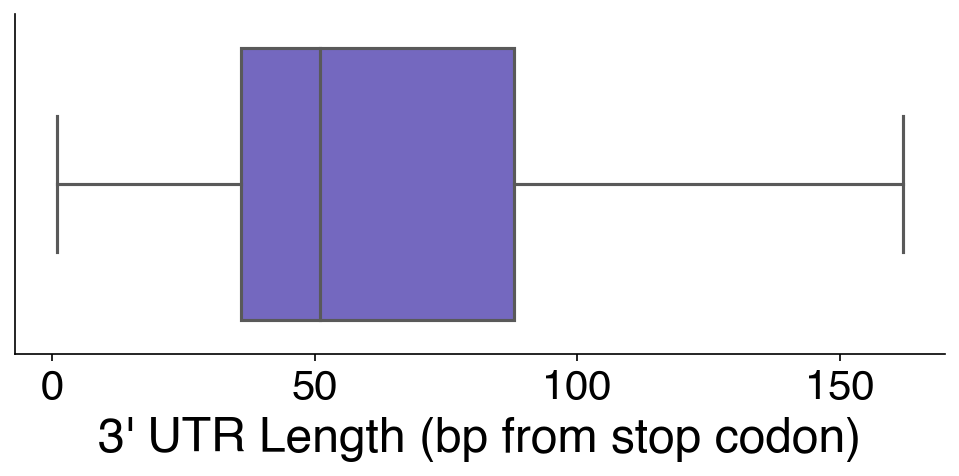

In [8]:
_, ax = plt.subplots(figsize=(8, 3))
sns.boxplot(np.array(five_prime_utr_lengths)*-1, showfliers=False, color='royalblue')
ax.set_xlabel("5' UTR Length (bp from start codon)", fontsize=23)
ax.tick_params(axis='both', labelsize='20')
ax.set_xticks([-250, -200, -150, -100, -50, 0])
ax.yaxis.set_ticks_position('none')
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(Path(FIG_PATH, 'five_prime.svg'))

_, ax = plt.subplots(figsize=(8, 3))
sns.boxplot(three_prime_utr_lengths, showfliers=False, color='slateblue')
ax.set_xlabel("3' UTR Length (bp from stop codon)", fontsize=23)
ax.tick_params(axis='both', labelsize='20')
ax.set_xticks([0, 50, 100, 150])
ax.yaxis.set_ticks_position('none')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(Path(FIG_PATH, 'three_prime.svg'))
plt.show()

### Bit Density

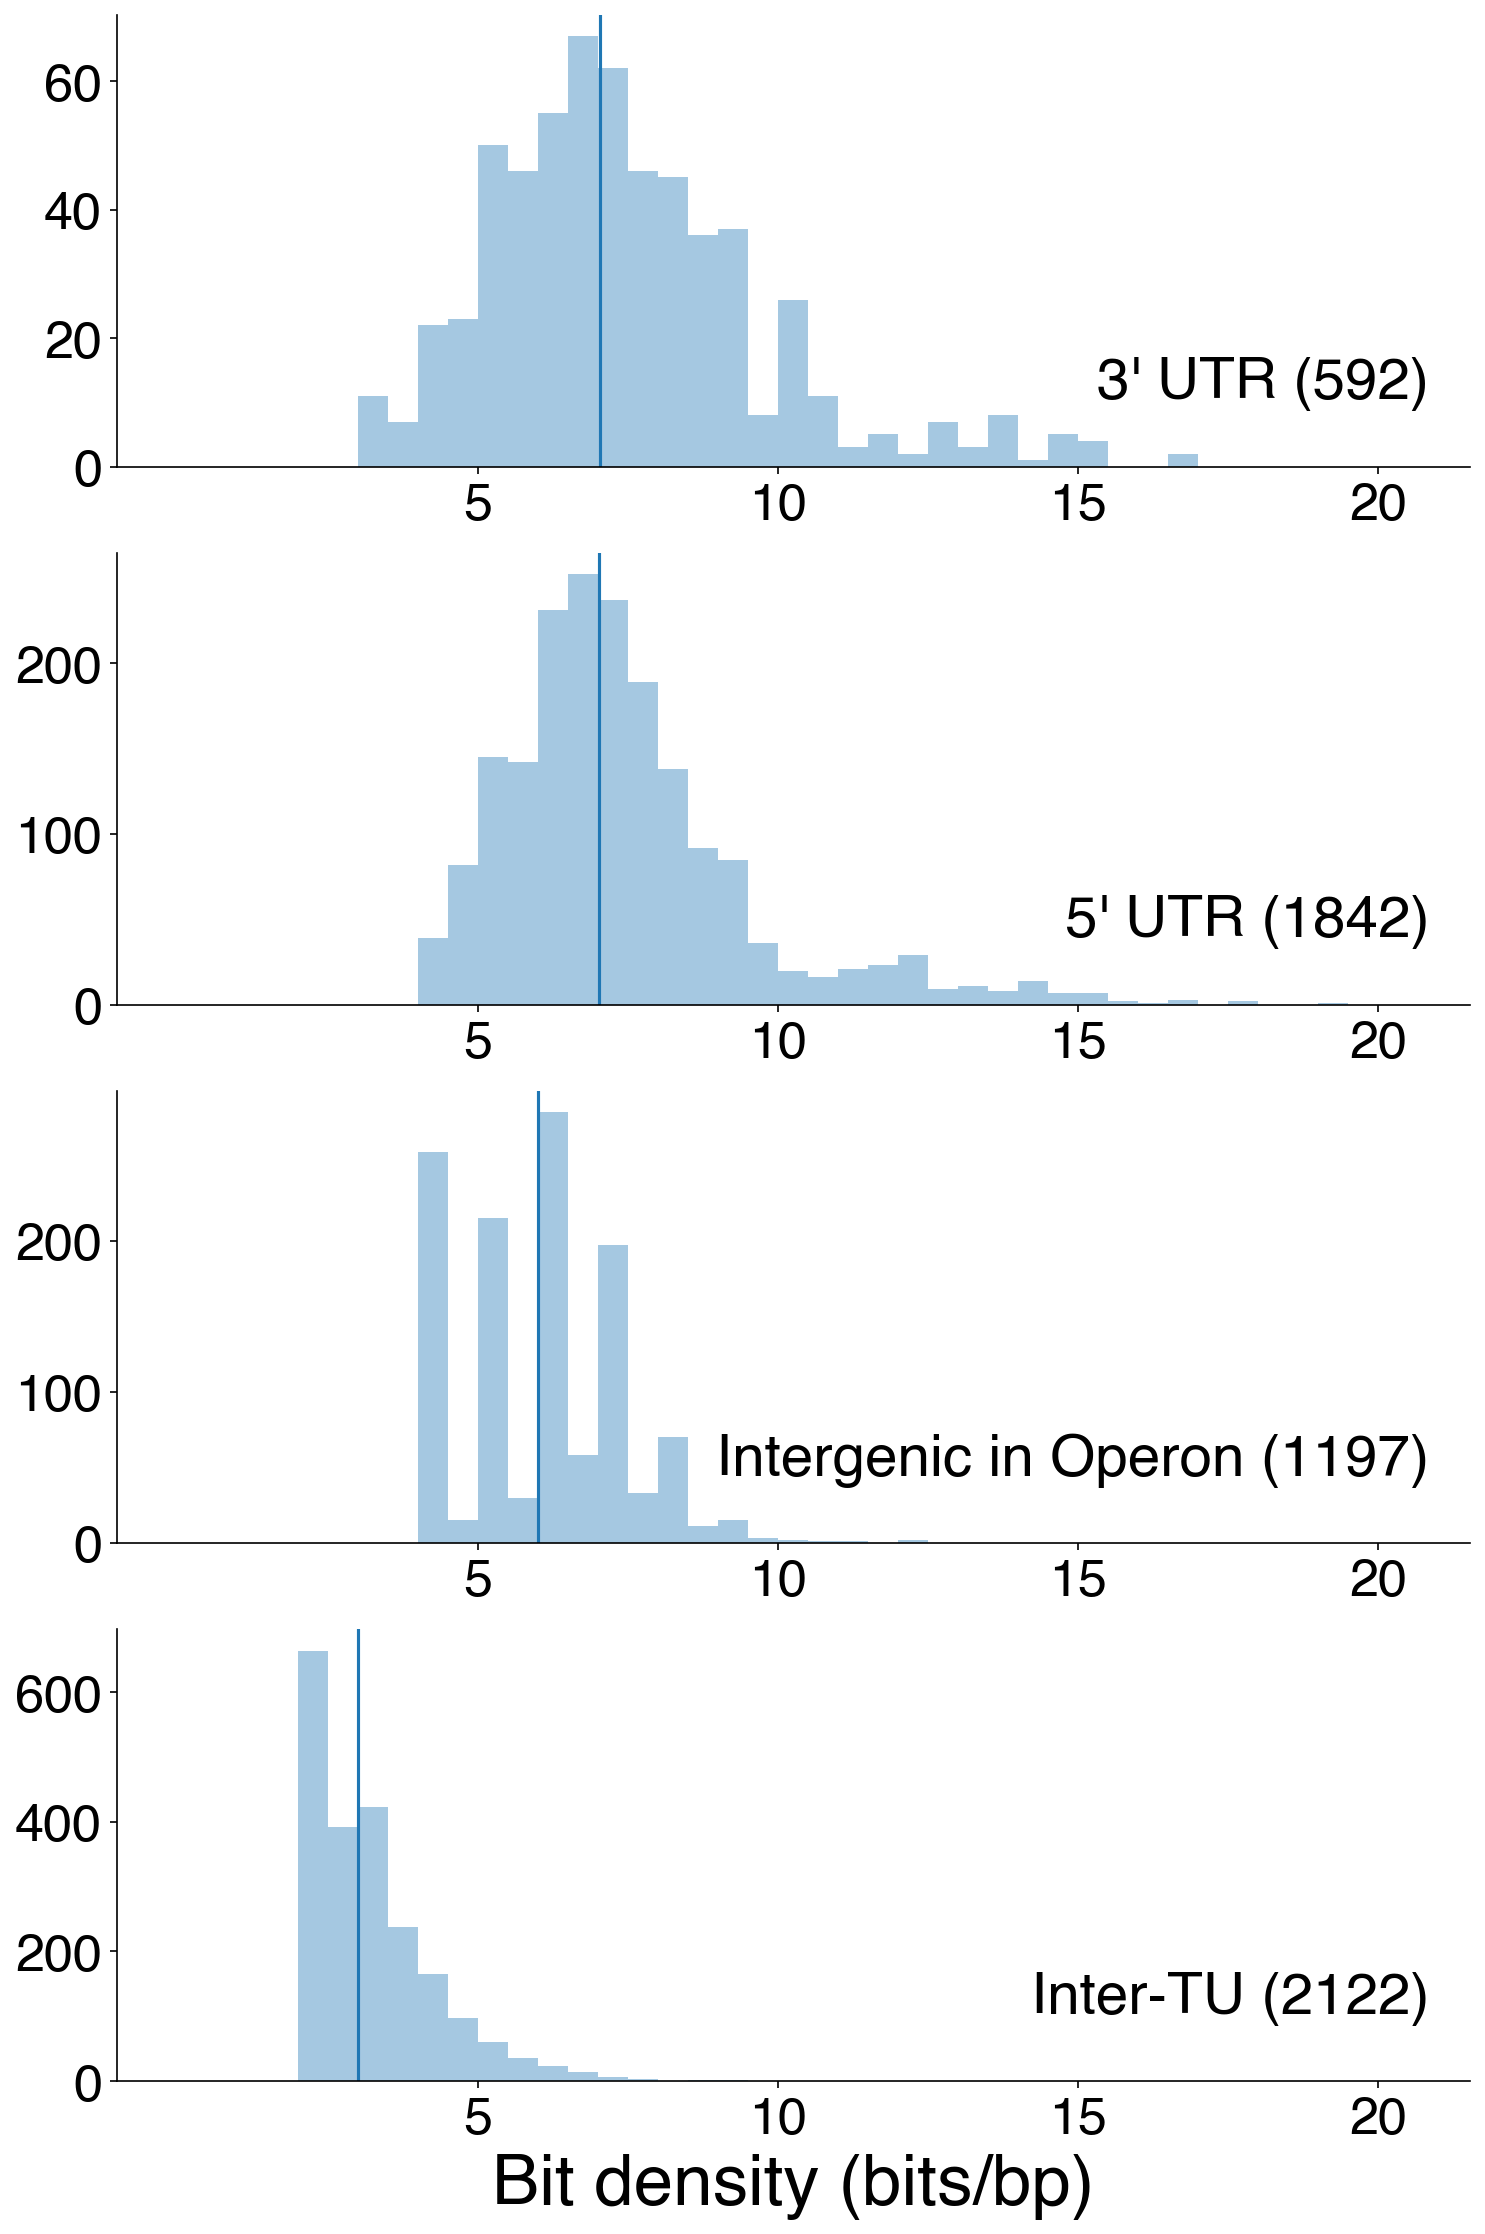

In [9]:
# want to highlight position of gadW/gadX
gadW = [gene for gene in test_bitome.genes if gene.name == 'gadW'][0]
gadX = [gene for gene in test_bitome.genes if gene.name == 'gadX'][0]
inter_gad_range = gadW.location.end.position, gadX.location.start.position
inter_gad_submat = test_bitome.extract(column_range=inter_gad_range)
inter_gad_bits_per_bp = inter_gad_submat.sum()/inter_gad_submat.shape[1]

axs = bits_per_bp_plot(
    test_bitome,
    [three_prime_utr_ranges_no_outliers, five_prime_utr_ranges_no_outliers, operon_intergenic_ranges, inter_tu_ranges],
    ["3' UTR", "5' UTR", "Intergenic in Operon", 'Inter-TU'],
    kde=False,
    figsize=(10, 15),
    median=True,
    show=False,
    return_axs=True
)
axs[-1].set_xlabel('Bit density (bits/bp)', fontsize=34)
plt.savefig(Path(FIG_PATH, 'bits_per_bp_intergenic.svg'))